In [131]:
# Importing
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
import seaborn as sns


## Getting data from SQL database

In [132]:
import pyodbc

In [133]:
connection = conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=LAPTOP-U3J291UT;DATABASE=BI_ETL;Trusted_Connection=yes;')

In [180]:
# Weather Data
SQL = "SELECT[all_data_id]" +\
      ",[sourceId]" +\
      ",[referenceTime]" +\
      ",[air_temperature]" +\
      ",[wind_speed]" +\
      ",[wind_from_direction]" +\
      ",[air_pressure_at_sea_level]" +\
      ",[cloud_area_fraction]" +\
      ",[bool_cloud_area_fraction_1D]" +\
      ",[precipitation_amount_1H]" +\
      "FROM [BI_ETL].[dbo].[all_measurements]"

df = pd.read_sql(SQL, connection, index_col='referenceTime')
df = df.dropna(subset=['sourceId'])
df['sourceId'] = df['sourceId'].map(lambda x: x[0:-2])
#df = df.set_index(df.referenceTime)
#df = df.loc[(df.referenceTime > np.datetime64('2010-01-01')) & (df.referenceTime < np.datetime64('2012-01-01'))]
df = df.loc['2010-01-01':'2012-01-01'].sort_index()
print(df.head())

                     all_data_id sourceId  air_temperature  wind_speed  \
referenceTime                                                            
2010-01-01 01:00:00         1979  SN44560            -11.7         0.8   
2010-01-01 01:00:00        53072  SN44580              NaN         NaN   
2010-01-01 01:00:00       371715  SN76925              3.5         5.6   
2010-01-01 01:00:00       371716  SN76925              3.5         5.6   
2010-01-01 01:00:00       371717  SN76925              3.5         5.6   

                     wind_from_direction  air_pressure_at_sea_level  \
referenceTime                                                         
2010-01-01 01:00:00                 88.0                     1005.0   
2010-01-01 01:00:00                  NaN                        NaN   
2010-01-01 01:00:00                116.0                     1006.7   
2010-01-01 01:00:00                116.0                     1006.7   
2010-01-01 01:00:00                116.0               

In [181]:
# Location Data
SQL = "SELECT [Locations_Id]" +\
              ",[Id] as sourceId" +\
              ",[country]" +\
              ",[countryCode]" +\
              ",[county]" +\
              ",[countyId]" +\
              ",[name]" +\
              ",[shortName]" +\
              ",[validFrom]" +\
      "FROM [BI_ETL].[dbo].[dim_locations]"


locations_df = pd.read_sql(SQL, connection)
locations_df = locations_df.dropna(subset=['sourceId'])
print(locations_df.head())

   Locations_Id sourceId country countryCode       county  countyId  \
1             1  SN44560   Norge          NO     ROGALAND      11.0   
2             2  SN44580   Norge          NO     ROGALAND      11.0   
3             3  SN76920   Norge          NO    NORDSJØEN      26.0   
4             4  SN76922   Norge          NO    NORDSJØEN      26.0   
5             5  SN76925   Norge          NO  NORSKEHAVET      24.0   

                name    shortName  validFrom  
1               SOLA         Sola 1935-05-21  
2  STAVANGER - MADLA         None 1983-07-08  
3            EKOFISK      Ekofisk 2014-04-01  
4        STATFJORD A  Statfjord A 2010-12-02  
5            DRAUGEN      Draugen 1993-10-01  


In [182]:
print(df.dtypes)

all_data_id                      int64
sourceId                        object
air_temperature                float64
wind_speed                     float64
wind_from_direction            float64
air_pressure_at_sea_level      float64
cloud_area_fraction            float64
bool_cloud_area_fraction_1D    float64
precipitation_amount_1H        float64
dtype: object


In [183]:
print(locations_df.dtypes)

Locations_Id             int64
sourceId                object
country                 object
countryCode             object
county                  object
countyId               float64
name                    object
shortName               object
validFrom       datetime64[ns]
dtype: object


#### Substitut sourceID with name of source

In [184]:
df['sourceName'] = df['sourceId'].map(lambda id: locations_df.loc[locations_df['sourceId'] == id].name.item())
print(df.head())

                     all_data_id sourceId  air_temperature  wind_speed  \
referenceTime                                                            
2010-01-01 01:00:00         1979  SN44560            -11.7         0.8   
2010-01-01 01:00:00        53072  SN44580              NaN         NaN   
2010-01-01 01:00:00       371715  SN76925              3.5         5.6   
2010-01-01 01:00:00       371716  SN76925              3.5         5.6   
2010-01-01 01:00:00       371717  SN76925              3.5         5.6   

                     wind_from_direction  air_pressure_at_sea_level  \
referenceTime                                                         
2010-01-01 01:00:00                 88.0                     1005.0   
2010-01-01 01:00:00                  NaN                        NaN   
2010-01-01 01:00:00                116.0                     1006.7   
2010-01-01 01:00:00                116.0                     1006.7   
2010-01-01 01:00:00                116.0               

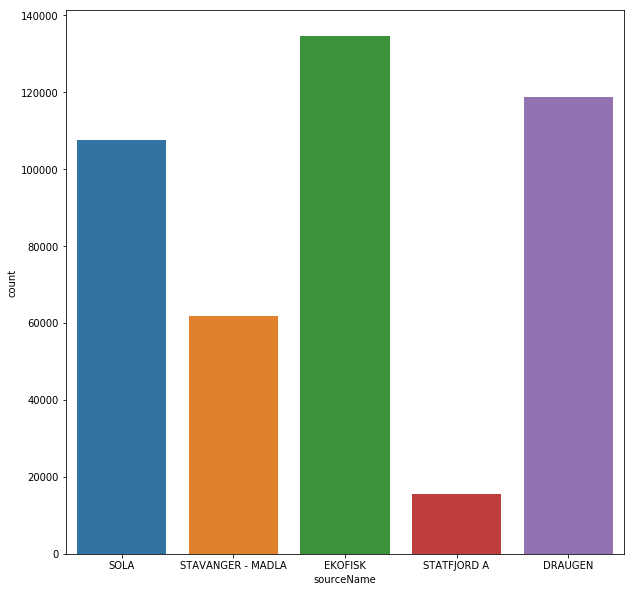

In [173]:
sns.countplot(x='sourceName', data=df)

In [176]:
for sourceName in ['SOLA', 'STAVANGER - MADLA', 'EKOFISK', 'DRAUGEN', 'STATFJORD']:
    a = pd.DataFrame({'x': df.loc[df['sourceName'] == sourceName].referenceTime[1:],
                      'y': df.loc[df['sourceName'] == sourceName].referenceTime.diff()[1:]/np.timedelta64(1, 'h')})
    a = a.loc[a.y != 0.0]
    sns.scatterplot(x='x',y='y',data=a, label=sourceName)

plt.xlim(['2010', '2012'])
plt.legend()

ValueError: cannot reindex from a duplicate axis

In [166]:
subset=['wind_speed']
for sourceName in ['SOLA', 'STAVANGER - MADLA', 'EKOFISK', 'DRAUGEN', 'STATFJORD']:
    a = pd.DataFrame({'x': df.dropna(subset=subset).resample('h').mean()
                             .sort_values(by='referenceTime')
                             .loc[df['sourceName'] == sourceName]
                             .referenceTime[1:],
                      'y': df.dropna(subset=subset).resample('h').mean()
                             .sort_values(by='referenceTime')
                             .loc[df['sourceName'] == sourceName]
                             .referenceTime.diff()[1:]/np.timedelta64(1, 'h')})
    a = a.loc[a.y != 0.0]
    a = a.set_index(a.x)
    a_hourly = a.resample('h').mean().fillna(100)
    print(a_hourly.head())
    print(a.head())
    sns.kdeplot(a_hourly.y.values, bw=0.2, label=sourceName)

plt.xlim([0, 3])
#plt.ylim([0, 30])
plt.legend()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [44]:
all(df.loc[df['sourceName'] == 'SOLA'].referenceTime.diff()[1:] == np.timedelta64(1, 'h')) == True

False

In [104]:
print(np.timedelta64('0', 'D') + np.timedelta64('0', 'h'))
df.sort_values(by='referenceTime').loc[df['sourceName'] == 'SOLA'].referenceTime.diff()[1:]/np.timedelta64(1, 'h')

0 hours


1980     0.000000
1998     0.333333
1997     0.000000
2016     0.500000
2015     0.000000
2034     0.166667
2033     0.000000
2052     0.833333
2051     0.000000
2069     0.166667
2070     0.000000
2088     0.833333
2087     0.000000
2105     0.166667
2106     0.000000
2123     0.833333
2124     0.000000
2142     0.166667
2141     0.000000
2160     0.333333
2159     0.000000
2178     0.500000
2177     0.000000
2196     0.166667
2195     0.000000
2213     0.333333
2214     0.000000
2232     0.500000
2231     0.000000
2250     0.166667
           ...   
79134    0.500000
79133    0.000000
79145    0.166667
79146    0.000000
79158    0.333333
79157    0.000000
79169    0.500000
79170    0.000000
79182    0.166667
79181    0.000000
79193    0.333333
79194    0.000000
79205    0.500000
79206    0.000000
79217    0.166667
79218    0.000000
79229    0.333333
79230    0.000000
79242    0.500000
79241    0.000000
79253    0.166667
79254    0.000000
79265    0.333333
79266    0.000000
79277    0

## Series plot

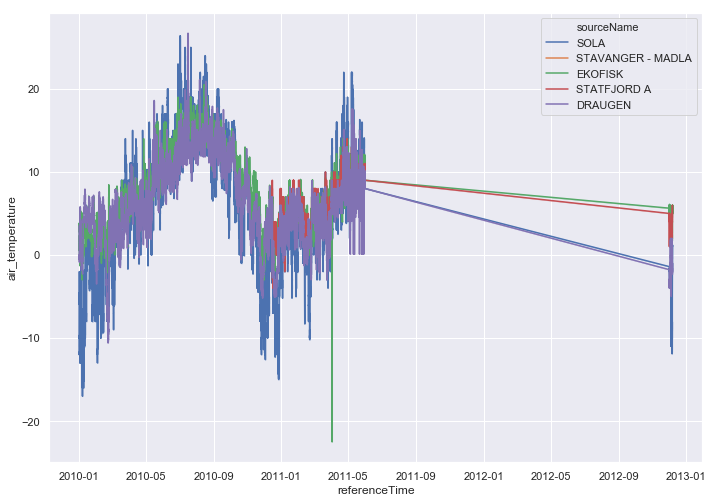

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="referenceTime", y="air_temperature",
             hue="sourceName",
             data=df)

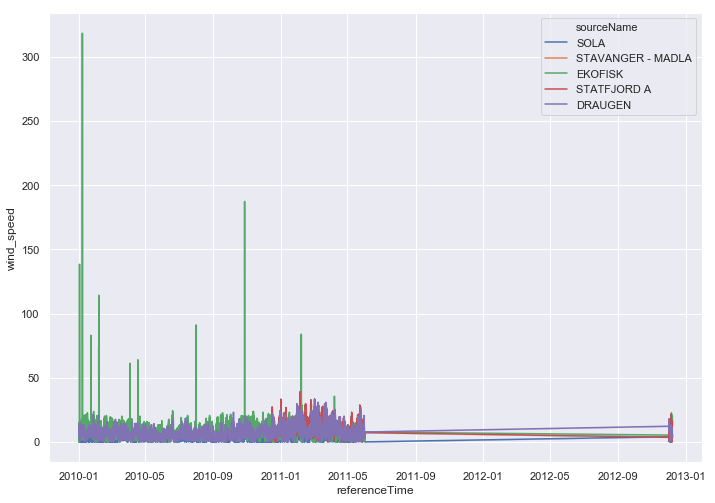

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="referenceTime", y="wind_speed",
             hue="sourceName",
             data=df)